##  Telecom churn group case study
In the telecommunication industry, customers tend to change operators if not provided with attractive schemes and offers. It is very important for any telecom operator to prevent the present customers from churning to other operators. As a data scientist, your task in this case study would be to build an ML model which can predict if the customer will churn or not in a particular month based on the past data.

In [129]:
import numpy as np
import pandas as pd
import re
import os


import sklearn
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
import missingno as msno

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

## Step 1 : Reading and understanding data

In [130]:
pd.set_option('display.max_columns', 200)
churndata = pd.read_csv('train.csv')
churndata.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

In [131]:
# Read data dictionary
data_dict = pd.read_csv('data_dictionary.csv')
sample = pd.read_csv('sample.csv')
unseen = pd.read_csv('test.csv')
#data_dict

##  Step 2: Selecting important columns

In [132]:
ids = ['id']

arpu = [i for i in list(churndata.columns)
if re.search('arpu.', i)]

total_outgoings = [i for i in list(churndata.columns)
if re.search('total.+og.+mou', i)]

total_amounts = [i for i in list(churndata.columns)
if re.search('total.+amt', i)]

volume_2g = [i for i in list(churndata.columns)
if re.search('vol.+2g.', i)]

volume_3g = [i for i in list(churndata.columns)
if re.search('vol.+3g.', i)]

age_of_network = [i for i in list(churndata.columns)
if re.search('aon', i)]

vbc = [i for i in list(churndata.columns)
if re.search('.+vbc.', i)]

In [133]:
variables = [*ids,
             *total_amounts,
             *arpu,
             *total_outgoings,
             *volume_2g,
             *volume_3g,
             *age_of_network,
             *vbc,
             'churn_probability']

data = churndata[variables].set_index('id')

In [134]:
data.head()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,arpu_6,arpu_7,arpu_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,,,,,,,
0,77,65,10,31.277,87.009,7.527,NaN,NaN,NaN,NaN,NaN,NaN,81.21,221.68,3.63,0.0,0.00,0.00,0.0,0.00,0.0,1958,0
1,0,145,50,0.000,122.787,42.953,NaN,122.07,NaN,NaN,122.08,NaN,0.00,30.73,31.66,0.0,352.91,0.00,0.0,3.96,0.0,710,0
2,70,120,0,60.806,103.176,0.000,NaN,NaN,NaN,NaN,NaN,NaN,56.49,99.36,0.00,0.0,0.00,0.00,0.0,0.00,0.0,882,0
3,160,240,130,156.362,205.260,111.095,NaN,NaN,NaN,NaN,NaN,NaN,76.03,95.98,53.84,0.0,0.00,0.00,0.0,0.00,0.0,982,0
4,290,136,122,240.708,128.191,101.565,0.0,35.00,0.0,0.0,35.12,0.0,63.26,42.94,15.76,390.8,308.89,213.47,0.0,0.00,0.0,647,0


In [135]:
data.shape

(69999, 23)

In [136]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69999 entries, 0 to 69998
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_rech_amt_6   69999 non-null  int64  
 1   total_rech_amt_7   69999 non-null  int64  
 2   total_rech_amt_8   69999 non-null  int64  
 3   arpu_6             69999 non-null  float64
 4   arpu_7             69999 non-null  float64
 5   arpu_8             69999 non-null  float64
 6   arpu_3g_6          17568 non-null  float64
 7   arpu_3g_7          17865 non-null  float64
 8   arpu_3g_8          18417 non-null  float64
 9   arpu_2g_6          17568 non-null  float64
 10  arpu_2g_7          17865 non-null  float64
 11  arpu_2g_8          18417 non-null  float64
 12  total_og_mou_6     69999 non-null  float64
 13  total_og_mou_7     69999 non-null  float64
 14  total_og_mou_8     69999 non-null  float64
 15  vol_2g_mb_6        69999 non-null  float64
 16  vol_2g_mb_7        699

In [137]:
data.describe(include='all')

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,arpu_6,arpu_7,arpu_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,aon,churn_probability
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,328.139788,322.376363,323.846355,283.134365,278.185912,278.858826,90.069931,89.115767,90.618564,86.863900,85.846074,86.348404,306.451436,310.572674,304.513065,51.773924,51.240204,50.127506,122.171882,128.934444,135.486541,1220.639709,0.101887
std,404.211068,411.070120,426.181405,334.213918,344.366927,351.924315,193.600413,195.826990,189.907986,171.321203,178.067280,170.297094,465.502866,479.131770,477.936832,212.513909,211.114667,213.101403,554.869965,554.096072,568.310234,952.426321,0.302502
min,0.000000,0.000000,0.000000,-2258.709000,-1289.715000,-945.808000,-20.380000,-26.040000,-24.490000,-35.830000,-13.090000,-55.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000
25%,110.000000,100.000000,90.000000,93.581000,86.714000,84.095000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.780000,42.910000,38.710000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000
50%,229.000000,220.000000,225.000000,197.484000,191.588000,192.234000,0.520000,0.420000,0.840000,11.300000,8.800000,9.090000,145.280000,141.230000,138.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000
75%,438.000000,430.000000,436.000000,370.791000,365.369500,369.909000,122.070000,120.860000,122.070000,122.070000,122.070000,122.070000,374.305000,380.045000,370.895000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000
max,35190.000000,40335.000000,45320.000000,27731.088000,35145.834000,33543.624000,5054.370000,4980.900000,3716.900000,5054.350000,4809.360000,3483.170000,10674.030000,8285.640000,14043.060000,10285.900000,7873.550000,11117.610000,45735.400000,28144.120000,30036.060000,4337.000000,1.000000


## Step 3: Create X, y and split data into train test set

In [138]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [139]:
X.shape, y.shape

((69999, 22), (69999,))

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.7, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48999, 22), (21000, 22), (48999,), (21000,))

<Axes: >

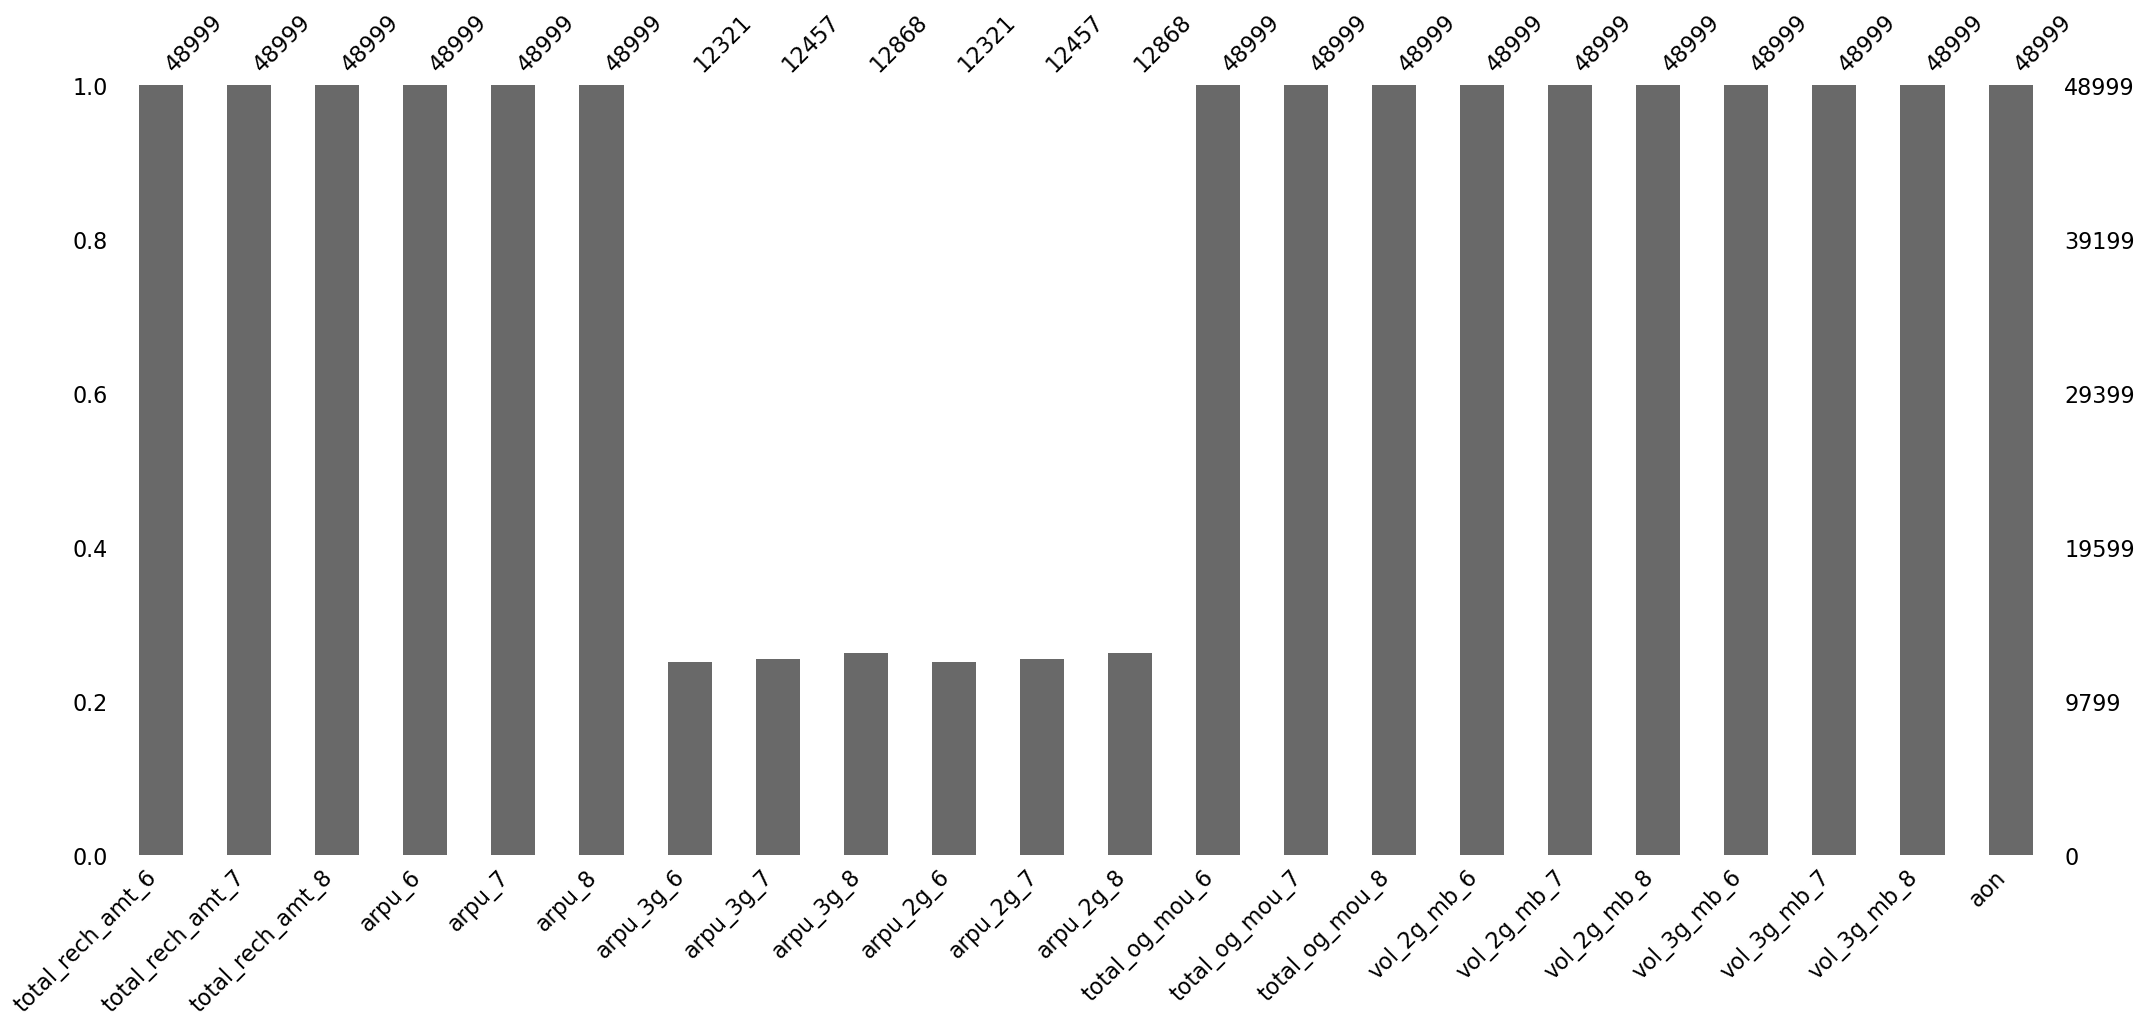

In [141]:
msno.bar(X_train)

##  Step 4: Handling missing values

In [142]:
missing_data_percentage = round(100*(X_train.isnull().sum() / len(X_train)), 2)
missing_data_percentage

total_rech_amt_6     0.00
total_rech_amt_7     0.00
total_rech_amt_8     0.00
arpu_6               0.00
arpu_7               0.00
arpu_8               0.00
arpu_3g_6           74.85
arpu_3g_7           74.58
arpu_3g_8           73.74
arpu_2g_6           74.85
arpu_2g_7           74.58
arpu_2g_8           73.74
total_og_mou_6       0.00
total_og_mou_7       0.00
total_og_mou_8       0.00
vol_2g_mb_6          0.00
vol_2g_mb_7          0.00
vol_2g_mb_8          0.00
vol_3g_mb_6          0.00
vol_3g_mb_7          0.00
vol_3g_mb_8          0.00
aon                  0.00
dtype: float64

In [143]:
new_vars =  missing_data_percentage[missing_data_percentage.le(40)].index
len(new_vars)

16

In [144]:
X_train_new = X_train[new_vars]
X_train_new.shape

(48999, 16)

In [145]:
X_test_new = X_test[new_vars]
X_test_new.shape

(21000, 16)

##  Step 5: Impute null values

In [146]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_new[new_vars] = imp.fit_transform(X_train_new[new_vars])
X_test_new[new_vars] = imp.transform(X_test_new[new_vars])

<Axes: >

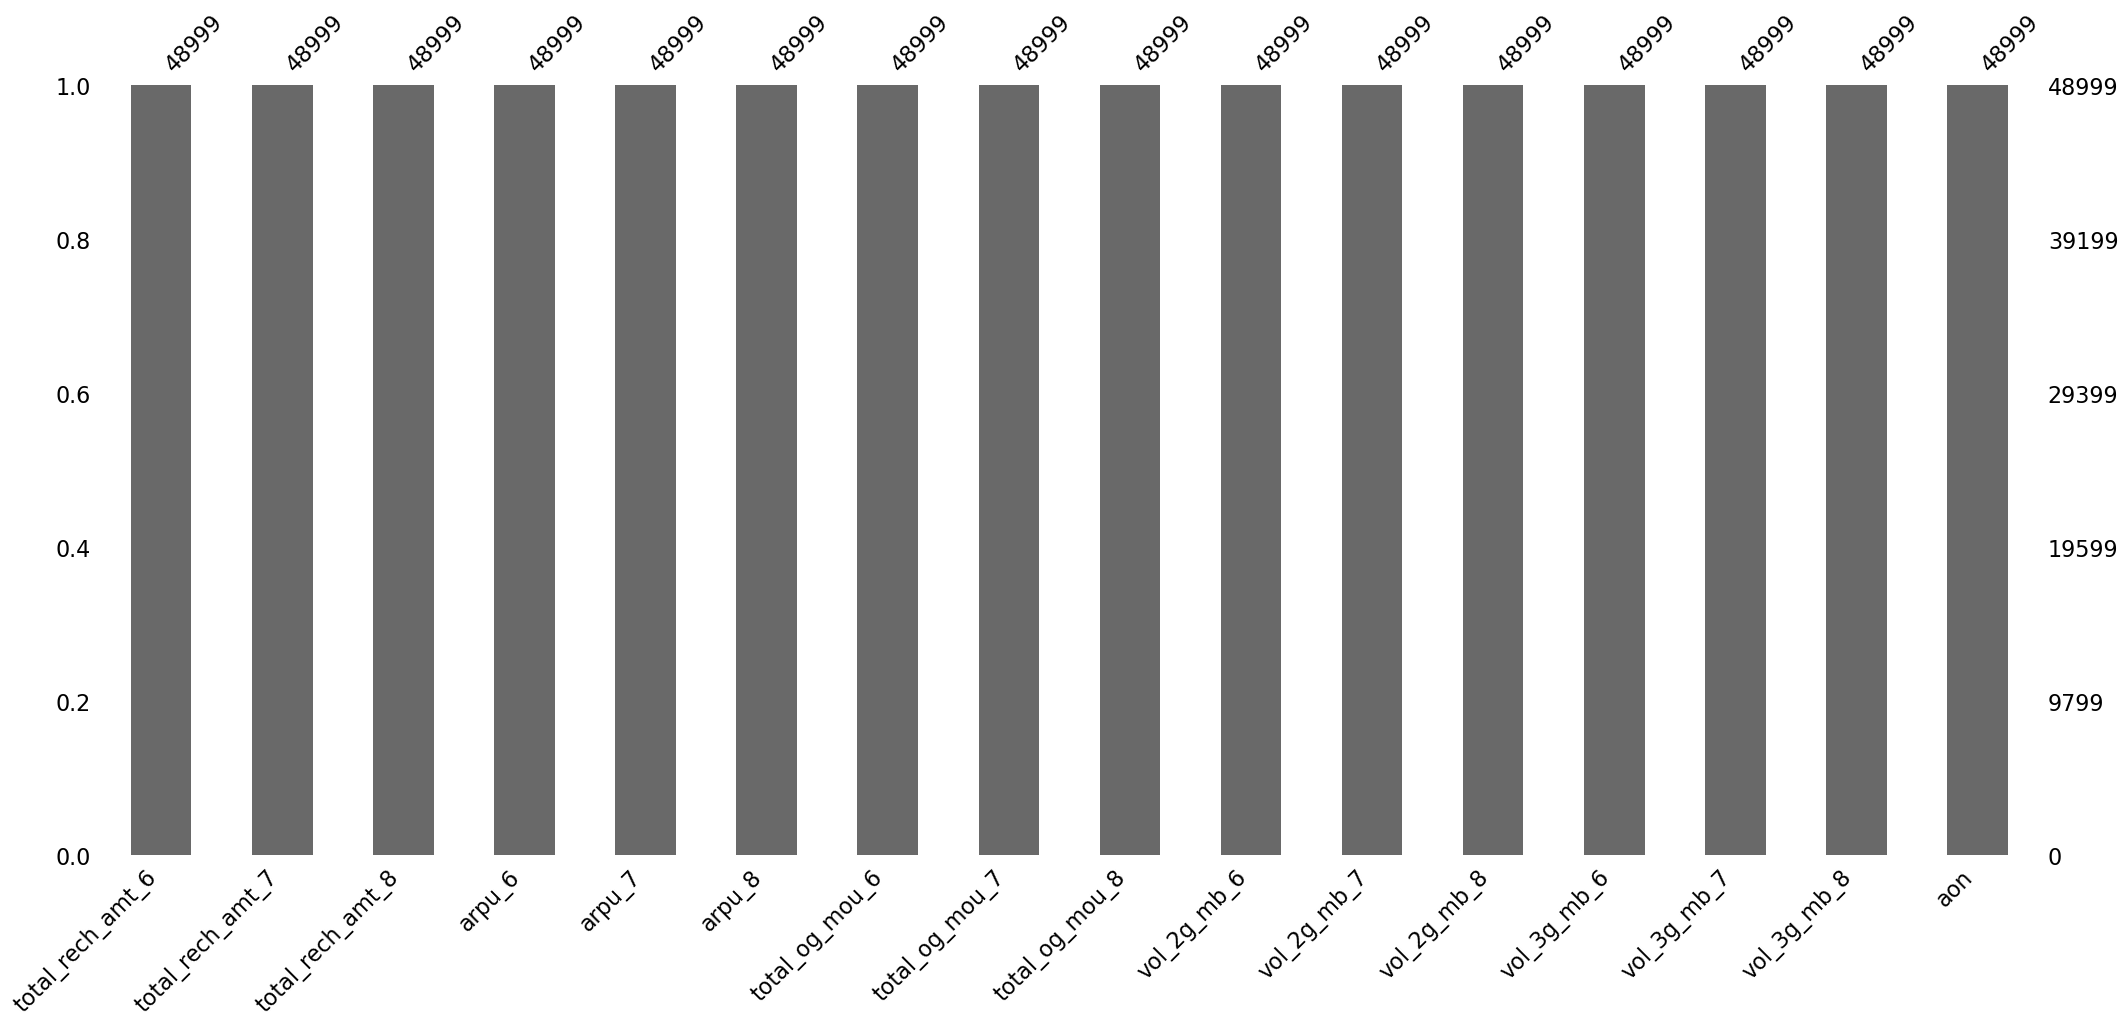

In [147]:
msno.bar(X_train_new)

## Step 5.1: Handling outliers

<Axes: >

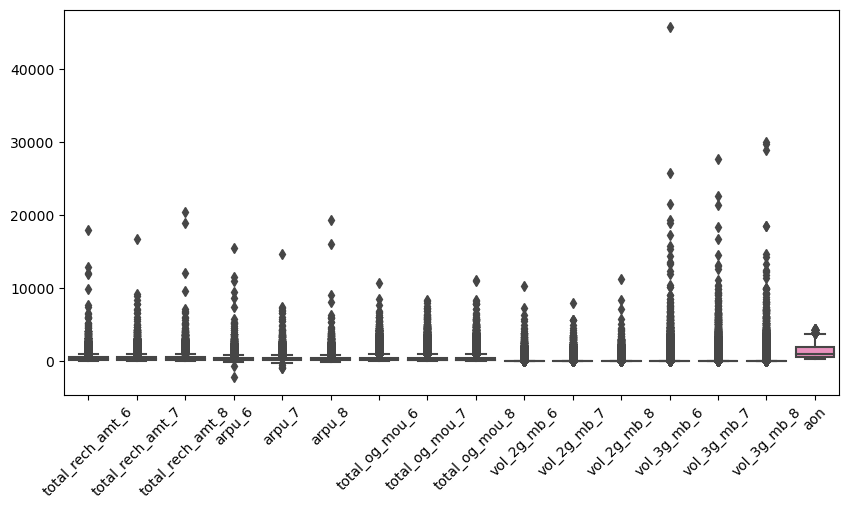

In [148]:
plt.figure(figsize=(10, 5))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_new)

In [149]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    
    
    array[array < lower_limit] = lower_limit
    array[array > upper_limit] = upper_limit
    return array

In [150]:
X_train_new = X_train_new.apply(cap_outliers, axis=0)
X_test_new = X_test_new.apply(cap_outliers, axis=0)

<Axes: >

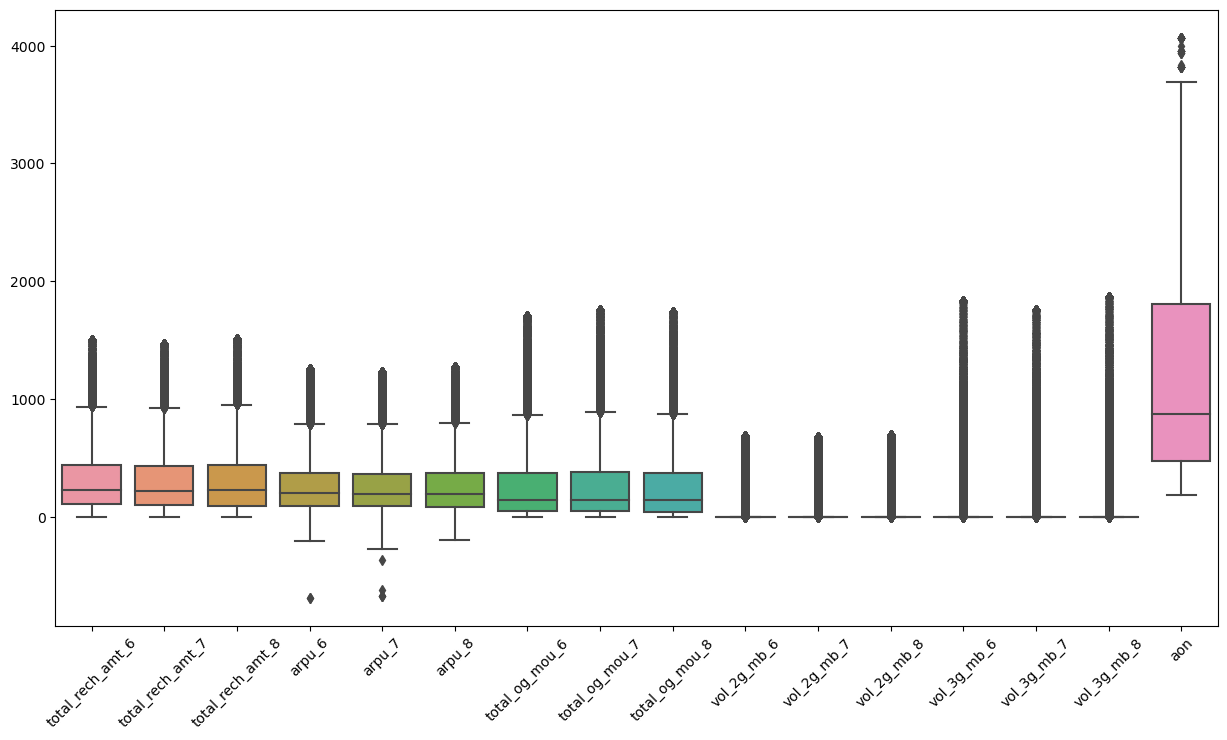

In [151]:
plt.figure(figsize=(15, 8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_new)

## Step 6: Feature scaling

In [152]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_new)
X_test_scaled = scaler.transform(X_test_new)

<Axes: >

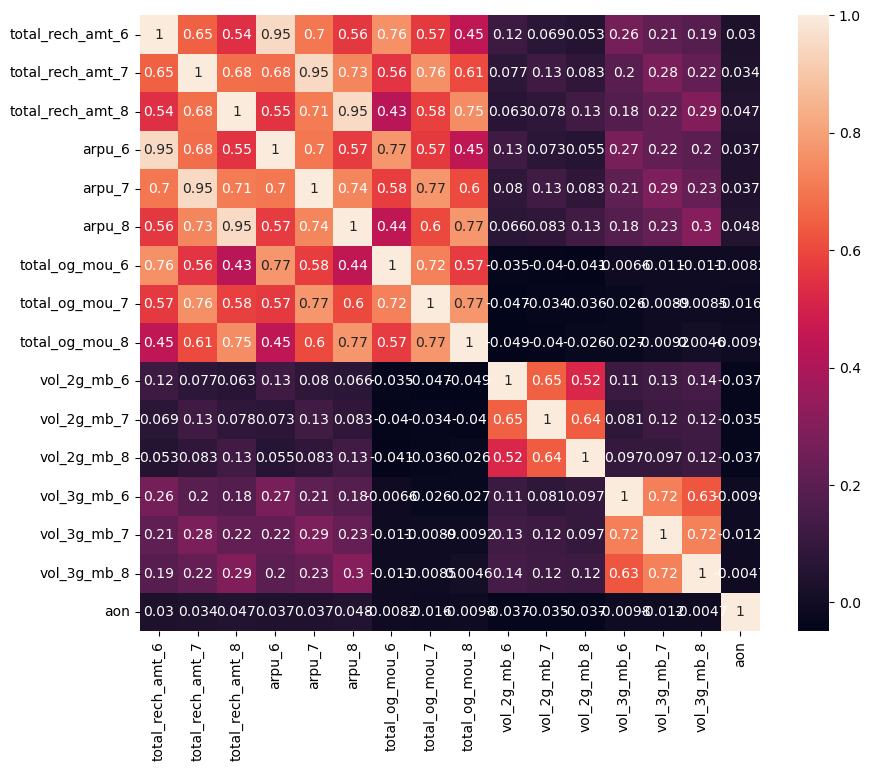

In [164]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_scaled, columns=new_vars).corr(), annot=True)

## Step 7: Implement XGBoost

In [153]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1, objective = "binary:logistic")
xgb_cfl.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [154]:
xgb_predictions = xgb_cfl.predict(X_test_scaled)
accuracy_score(y_test, xgb_predictions)

0.9328095238095238

##  Step 8: Hyperparameter tuning

In [155]:
params = {
    'n_estimators' : [100, 200, 500, 750],
    'learning_rate' : [0.1, 0.02, 0.05, 0.1, 0.25],
    'min_child_weight' : [1, 5, 7, 10],
    'gamma' : [0.1, 0.5, 1, 1.5, 5],
    'subsample' : [0.6, 0.8, 1.0],
    'colsample_bytree' : [0.6, 0.8, 1.0],
    'max_depth' : [3, 4, 5, 10, 12]    
}

folds = 5
param_comb = 10
random_search = RandomizedSearchCV(xgb_cfl, param_distributions = params, n_iter = param_comb, scoring= 'accuracy', n_jobs = -1, cv = 5, verbose = 3, random_state = 42)

In [156]:
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.1, 0.5, 1, 1.5, 5],
                                        'learning_rate': [0.1, 0.02, 0.05, 0.1,
                                                          0.25],
                                        'max_depth': [3, 4, 5, 10, 12],
                                        'min_child_weight': [1, 5, 7, 10],
                                        'n_estimators': [100, 200, 500, 750],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=3)

In [157]:
xgb_predictions_hpt_train = random_search.predict(X_train_scaled)

In [158]:
accuracy_score(y_train, xgb_predictions_hpt_train)

0.9347741790648789

In [159]:
xgb_predictions_hpt = random_search.predict(X_test_scaled)

In [160]:
accuracy_score(y_test, xgb_predictions_hpt)

0.9354761904761905

##  Step 9:Prediction on unseen set

In [161]:
unseen_new = unseen[new_vars]
unseen_new[new_vars] = imp.transform(unseen_new[new_vars])
unseen_new = unseen_new.apply(cap_outliers, axis=0)
unseen_new_scaled = scaler.transform(unseen_new)

In [162]:
unseen['churn_probability'] = random_search.predict(unseen_new_scaled)
output = unseen[['id', 'churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0


In [163]:
output.to_csv('Submission.csv', index=False)